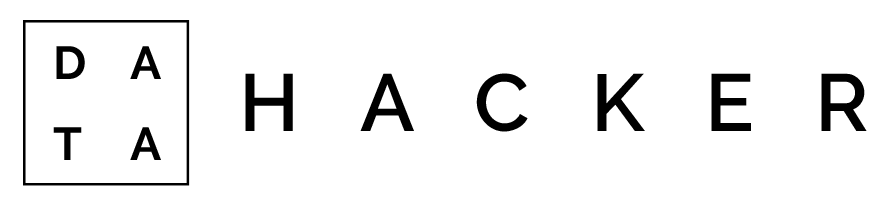
# Siamese Networks

## part 1.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [ ]:
# Creating some helper functions
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})

    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [ ]:
class SiameseNetworkDataset(Dataset):
    def __init__(self,imageFolderDataset,transform=None):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform

    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)

        #We need to approximately 50% of images to be in the same class
        should_get_same_class = random.randint(0,1)
        if should_get_same_class:
            while True:
                #Look untill the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:

            while True:
                #Look untill a different class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs)
                if img0_tuple[1] != img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        img0 = img0.convert("L")
        img1 = img1.convert("L")

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32))

    def __len__(self):
        return len(self.imageFolderDataset.imgs)

Download the dataset from our [GitHub](https://github.com/maticvl/dataHacker/blob/master/DATA/at%26t.zip) profile, just by running the code below.

In [ ]:
!wget https://github.com/maticvl/dataHacker/raw/master/DATA/at%26t.zip
!rm -rf data
!unzip "at&t.zip" -d .

--2024-11-14 23:06:32--  https://github.com/maticvl/dataHacker/raw/master/DATA/at%26t.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/maticvl/dataHacker/master/DATA/at%26t.zip [following]
--2024-11-14 23:06:33--  https://raw.githubusercontent.com/maticvl/dataHacker/master/DATA/at%26t.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3797060 (3.6M) [application/zip]
Saving to: ‘at&t.zip’

at&t.zip            100%[===================>]   3.62M  --.-KB/s    in 0.1s    

2024-11-14 23:06:33 (33.8 MB/s) - ‘at&t.zip’ saved [3797060/3797060]

Archive:  at&t.zip
   creating: ./data/
   creating: .

In [ ]:
# Load the training dataset
folder_dataset = datasets.ImageFolder(root="./data/faces/training/")

In [ ]:
# Resize the images and transform to tensors
transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor()
                                    ])

# Initialize the network
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transformation)

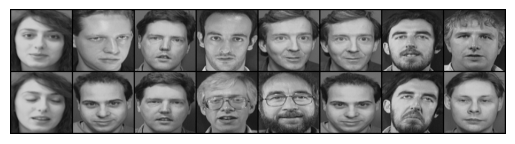

[0. 1. 0. 1. 1. 1. 0. 1.]


In [ ]:
# Create a simple dataloader just for simple visualization
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=8)

# Extract one batch
example_batch = next(iter(vis_dataloader))

# Example batch is a list containing 2x8 images, indexes 0 and 1, an also the label
# If the label is 1, it means that it is not the same person, label is 0, same person in both images
concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

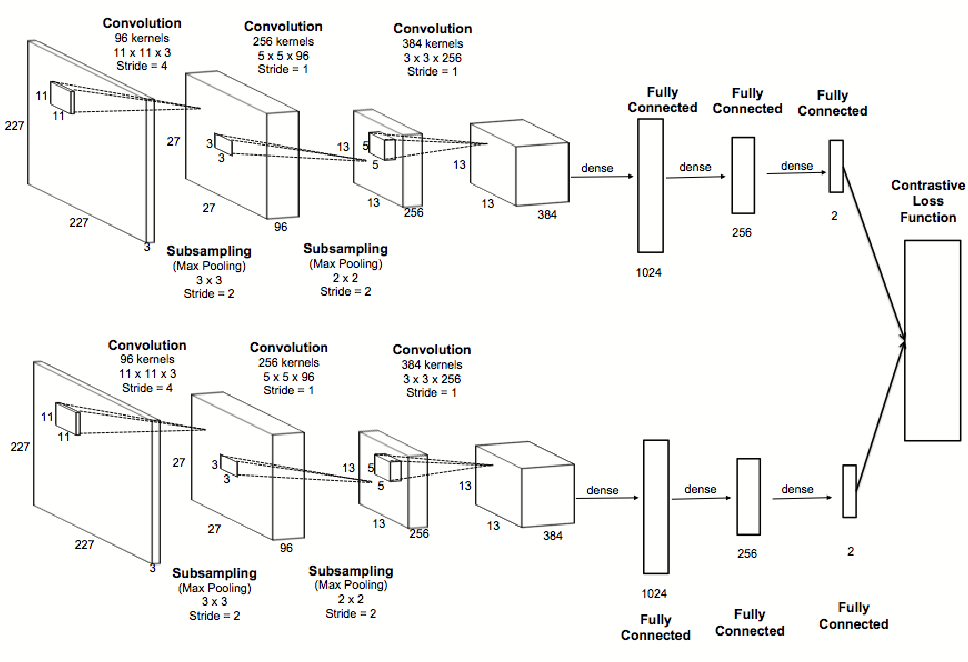

In [ ]:
#create the Siamese Neural Network
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11,stride=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 384, kernel_size=3,stride=1),
            nn.ReLU(inplace=True)
        )

        # Setting up the Fully Connected Layers
        self.fc1 = nn.Sequential(
            nn.Linear(384, 1024),
            nn.ReLU(inplace=True),

            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),

            nn.Linear(256,2)
        )

    def forward_once(self, x):
        # This function will be called for both images
        # It's output is used to determine the similiarity
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2

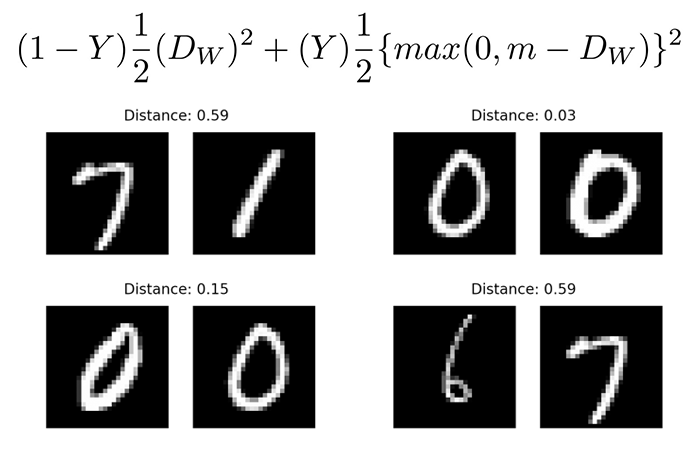

In [ ]:
# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidian distance and calculate the contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

In [ ]:
# Load the training dataset
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=64)

In [ ]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0005 )

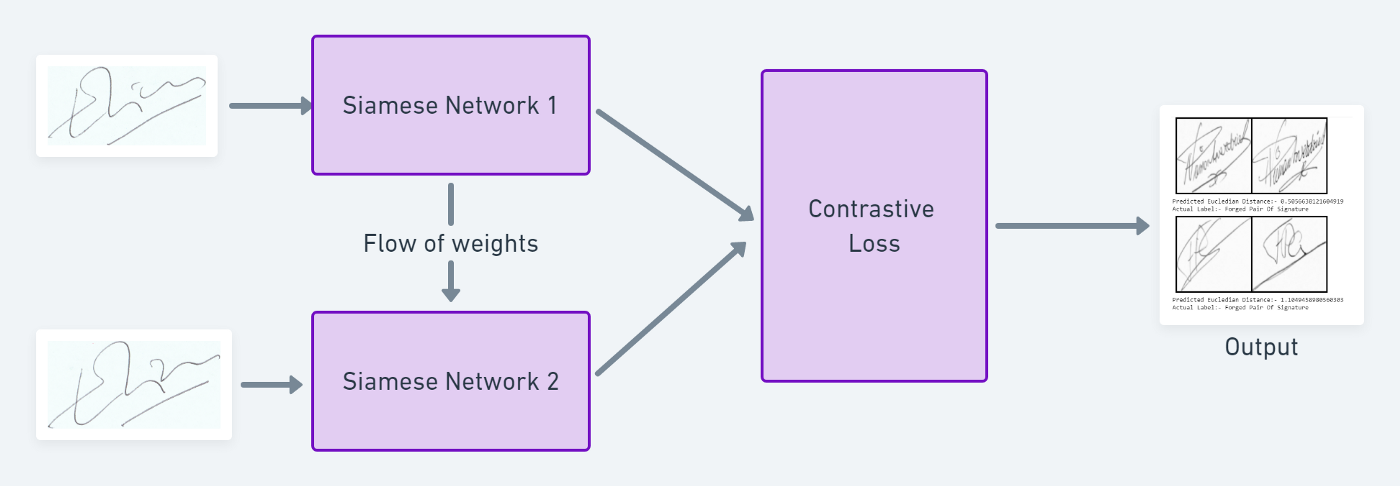

Epoch number 0
 Current loss 1.1982477903366089

Epoch number 1
 Current loss 1.328489065170288

Epoch number 2
 Current loss 1.7193537950515747

Epoch number 3
 Current loss 1.958682894706726

Epoch number 4
 Current loss 1.7805731296539307

Epoch number 5
 Current loss 1.7193101644515991

Epoch number 6
 Current loss 1.394446849822998

Epoch number 7
 Current loss 1.5863534212112427

Epoch number 8
 Current loss 1.1741628646850586

Epoch number 9
 Current loss 1.028975248336792

Epoch number 10
 Current loss 0.6185509562492371

Epoch number 11
 Current loss 0.5387254357337952

Epoch number 12
 Current loss 0.21611690521240234

Epoch number 13
 Current loss 0.1476631909608841

Epoch number 14
 Current loss 0.17279651761054993

Epoch number 15
 Current loss 0.05817653238773346

Epoch number 16
 Current loss 0.31673407554626465

Epoch number 17
 Current loss 0.04641915485262871

Epoch number 18
 Current loss 0.15810590982437134

Epoch number 19
 Current loss 0.049231112003326416

Epoch 

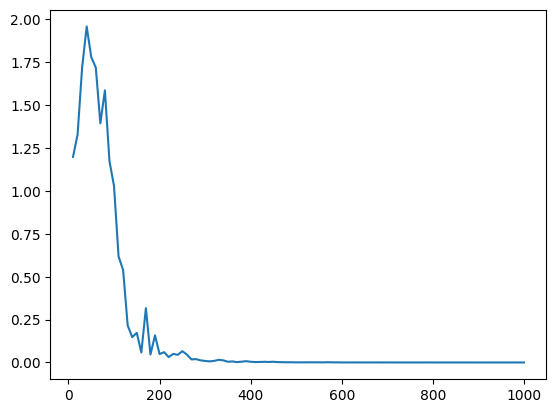

In [ ]:
counter = []
loss_history = []
iteration_number= 0

# Iterate throught the epochs
for epoch in range(100):

    # Iterate over batches
    for i, (img0, img1, label) in enumerate(train_dataloader, 0):

        # Send the images and labels to CUDA
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()

        # Zero the gradients
        optimizer.zero_grad()

        # Pass in the two images into the network and obtain two outputs
        output1, output2 = net(img0, img1)

        # Pass the outputs of the networks and label into the loss function
        loss_contrastive = criterion(output1, output2, label)

        # Calculate the backpropagation
        loss_contrastive.backward()

        # Optimize
        optimizer.step()

        # Every 10 batches print out the loss
        if i % 10 == 0 :
            print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

show_plot(counter, loss_history)

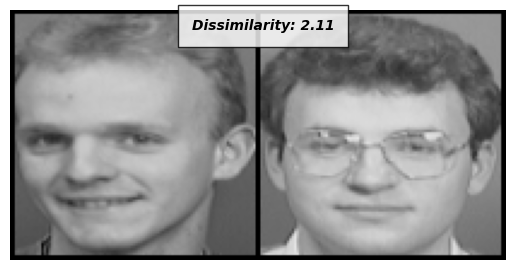

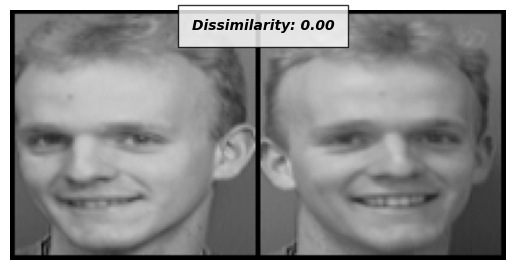

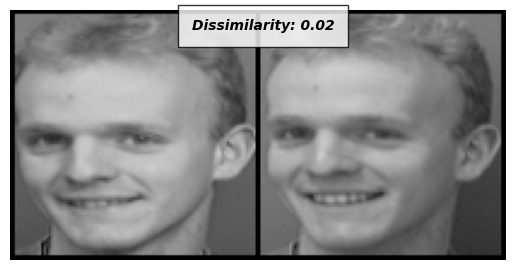

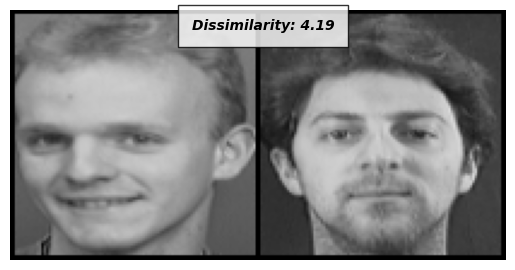

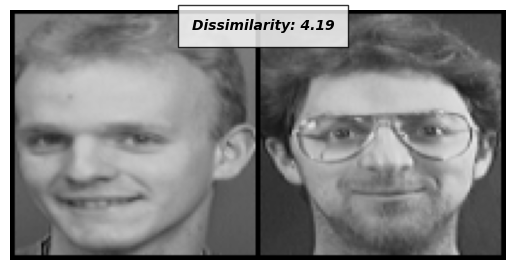

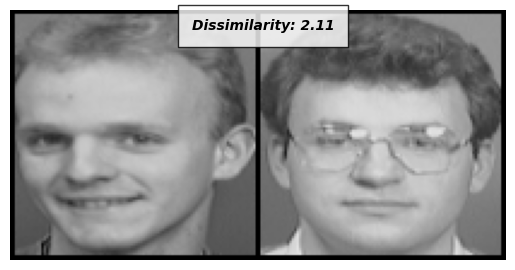

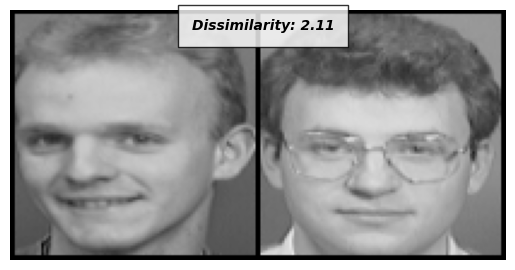

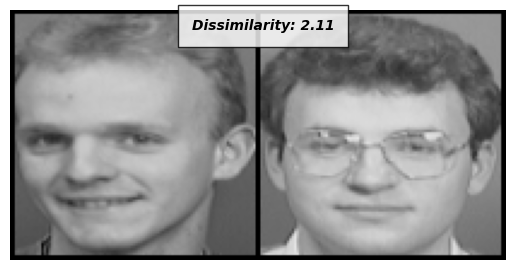

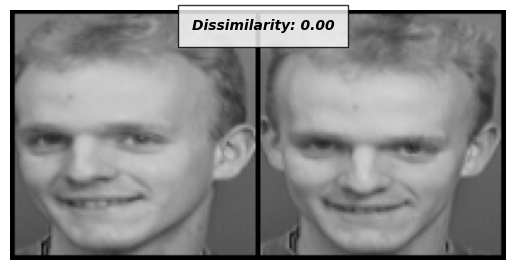

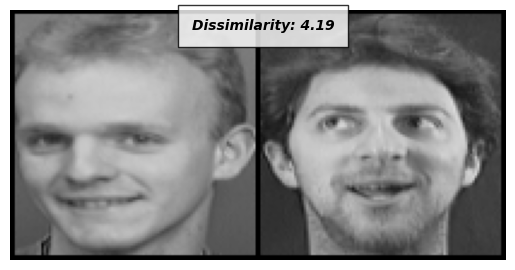

In [ ]:
# Locate the test dataset and load it into the SiameseNetworkDataset
folder_dataset_test = datasets.ImageFolder(root="./data/faces/testing/")
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transformation)
test_dataloader = DataLoader(siamese_dataset, num_workers=2, batch_size=1, shuffle=True)

# Grab one image that we are going to test
dataiter = iter(test_dataloader)
x0, _, _ = next(dataiter)

for i in range(10):
    # Iterate over 10 images and test them with the first image (x0)
    _, x1, label2 = next(dataiter)

    # Concatenate the two images together
    concatenated = torch.cat((x0, x1), 0)

    output1, output2 = net(x0.cuda(), x1.cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    imshow(torchvision.utils.make_grid(concatenated), f'Dissimilarity: {euclidean_distance.item():.2f}')

## part 2.

In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics import roc_curve, auc
import numpy as np

def calculate_distances_and_labels(dataloader, net):
    y_scores = []
    y_true = []

    net.eval()
    with torch.no_grad():
        for data in dataloader:
            x0, x1, label = data
            x0, x1 = x0.cuda(), x1.cuda()
            output1, output2 = net(x0, x1)
            euclidean_distance = F.pairwise_distance(output1, output2)

            # add distance and label into the list
            y_scores.extend(euclidean_distance.cpu().numpy())
            y_true.extend(label.cpu().numpy())

    return y_scores, y_true

y_scores, y_true = calculate_distances_and_labels(test_dataloader, net)

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print('AUC:', roc_auc)
print('Best threshold', optimal_threshold)


AUC: 0.9537037037037037
Best threshold 1.594944


## part 3.

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

%cd /content/drive/My Drive/301 HW/

/content/drive/My Drive/301 HW


In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import pandas as pd

image_dir = 'MeGlass_120x120/'
gallery_no_glass = 'MeGlass-master/test/gallery_no_glass.txt'
gallery_black_glass = 'MeGlass-master/test/gallery_black_glass.txt'
probe_no_glass = 'MeGlass-master/test/probe_no_glass.txt'
probe_black_glass = 'MeGlass-master/test/probe_black_glass.txt'

merged_no_glass_file = 'merged_no_glass.txt'
merged_black_glass_file = 'merged_black_glass.txt'

def merge_files(file1, file2, output_file):
    with open(output_file, 'w') as outfile:
        for fname in [file1, file2]:
            with open(fname) as infile:
                for line in infile:
                    if os.path.isfile(f"{image_dir}{line.strip()}"):
                        outfile.write(line)


merge_files(gallery_no_glass, probe_no_glass, merged_no_glass_file)

merge_files(gallery_black_glass, probe_black_glass, merged_black_glass_file)

In [ ]:
class GlassComparisonDataset(Dataset):
    def __init__(self, no_glass_images, black_glass_images, image_dir, transform=None):
        self.no_glass_images = no_glass_images
        self.black_glass_images = black_glass_images
        self.image_dir = image_dir
        self.transform = transform
        self.no_glass_dict = self.group_images_by_identity(no_glass_images)
        self.black_glass_dict = self.group_images_by_identity(black_glass_images)
        self.valid_identities = list(set(self.no_glass_dict.keys()) & set(self.black_glass_dict.keys()))
        self.pairs = self.create_pairs()

    def group_images_by_identity(self, images):
        identity_dict = {}
        for img_name in images:
            identity = get_identity(img_name)
            if identity not in identity_dict:
                identity_dict[identity] = []
            identity_dict[identity].append(img_name)
        return identity_dict

    def create_pairs(self):
        pairs = []
        for identity in self.valid_identities:

            no_glass_filename = self.no_glass_dict[identity][0]
            black_glass_filename = self.black_glass_dict[identity][0]
            pairs.append((no_glass_filename, black_glass_filename, identity))
        return pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        no_glass_filename, black_glass_filename, identity = self.pairs[idx]


        no_glass_path = os.path.join(self.image_dir, no_glass_filename)
        black_glass_path = os.path.join(self.image_dir, black_glass_filename)

        img_no_glass = Image.open(no_glass_path).convert("L")
        img_black_glass = Image.open(black_glass_path).convert("L")


        if self.transform:
            img_no_glass = self.transform(img_no_glass)
            img_black_glass = self.transform(img_black_glass)


        label = torch.tensor([0], dtype=torch.float32)

        return img_no_glass, img_black_glass, no_glass_filename, black_glass_filename, label

def get_identity(filename):
    return filename.split('@')[0] + "@" + filename.split('@')[1]


In [ ]:
no_glass_file = 'merged_no_glass.txt'
black_glass_file = 'merged_black_glass.txt'
image_dir = 'MeGlass_120x120/'

with open(no_glass_file, 'r') as f:
    no_glass_images = [line.strip() for line in f.readlines()]

with open(black_glass_file, 'r') as f:
    black_glass_images = [line.strip() for line in f.readlines()]


In [ ]:
transformation = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor()
                                    ])

glass_comparison_dataset = GlassComparisonDataset(no_glass_images, black_glass_images, image_dir=image_dir, transform=transformation)


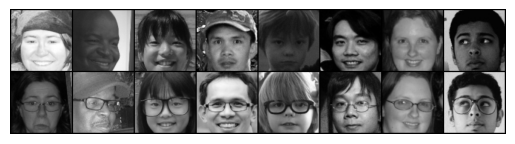

In [ ]:
# Create a simple dataloader just for simple visualization
glass_dataloader = DataLoader(glass_comparison_dataset,shuffle=True,
                        num_workers=2,
                        batch_size=8)


# Extract one batch
example_batch = next(iter(glass_dataloader))

concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))


In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

similarity_threshold = 1.594944
batch_size = 64

test_dataloader = DataLoader(glass_comparison_dataset, batch_size=batch_size, shuffle=True)

correct = 0
total = 0


with torch.no_grad():
    for x0, x1, _, _, label in test_dataloader:
        # GPU
        x0, x1 = x0.cuda(), x1.cuda()

        # get features
        output1, output2 = net(x0, x1)

        # distance
        euclidean_distances = F.pairwise_distance(output1, output2)

        for i in range(euclidean_distances.size(0)):
            prediction = 0 if euclidean_distances[i].item() < similarity_threshold else 1
            if prediction == label[i].item():
                correct += 1
            total += 1

accuracy = correct / total
print(f'Model Accuracy on Same-Person Pairs: {accuracy:.2%}')


Model Accuracy on Same-Person Pairs: 10.35%


## Part 4

In [ ]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=64)

net = SiameseNetwork().cuda()

optimizer = optim.Adam(net.parameters(), lr = 0.0005 )

In [ ]:

class MiningContrastiveLoss(nn.Module):
    def __init__(self):
        super(MiningContrastiveLoss, self).__init__()

    def forward(self, output1, output2, label):
        # Compute cosine similarity between pairs
        cosine_similarity = F.cosine_similarity(output1, output2)

        # Ensure label is a 1D tensor
        label = label.view(-1)

        # Separate positive and negative pairs based on labels
        positive_pairs = cosine_similarity[label == 1]
        negative_pairs = cosine_similarity[label == 0]

        # Calculate positive loss (maximize cosine similarity)
        if positive_pairs.numel() > 0:
            positive_loss = -positive_pairs.mean()  # Want high similarity for positives
        else:
            positive_loss = torch.tensor(0.0, device=output1.device)

        # Calculate negative loss (minimize cosine similarity)
        if negative_pairs.numel() > 0:
            negative_loss = negative_pairs.mean()  # Want low similarity for negatives
        else:
            negative_loss = torch.tensor(0.0, device=output1.device)


        loss = 0.5 * (positive_loss + negative_loss)
        return loss


Epoch number 0
 Current loss 1.996755599975586e-05

Epoch number 1
 Current loss 0.0002525448799133301

Epoch number 2
 Current loss 0.0005868971347808838

Epoch number 3
 Current loss 4.589557647705078e-06

Epoch number 4
 Current loss 1.430511474609375e-06

Epoch number 5
 Current loss 2.7120113372802734e-06

Epoch number 6
 Current loss 1.3709068298339844e-06

Epoch number 7
 Current loss 3.5762786865234375e-07

Epoch number 8
 Current loss 2.384185791015625e-07

Epoch number 9
 Current loss 5.960464477539063e-08

Epoch number 10
 Current loss 1.1920928955078125e-07

Epoch number 11
 Current loss 0.0

Epoch number 12
 Current loss 5.960464477539063e-08

Epoch number 13
 Current loss 0.0

Epoch number 14
 Current loss 2.9802322387695312e-08

Epoch number 15
 Current loss 5.960464477539063e-08

Epoch number 16
 Current loss 5.960464477539063e-08

Epoch number 17
 Current loss 5.960464477539063e-08

Epoch number 18
 Current loss 1.1920928955078125e-07

Epoch number 19
 Current loss 5.9

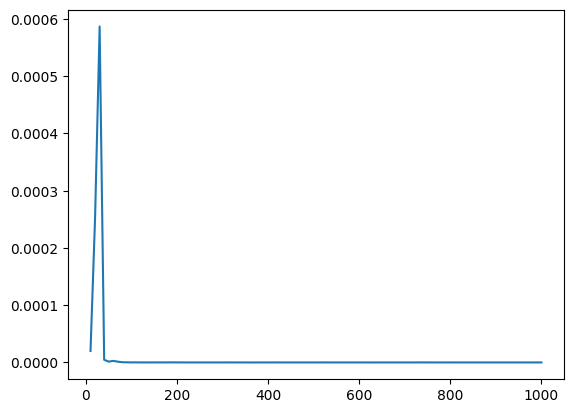

In [ ]:
counter = []
loss_history = []
iteration_number= 0
criterion = MiningContrastiveLoss()

for epoch in range(100):


    for i, (img0, img1, label) in enumerate(train_dataloader, 0):

        # Send the images and labels to CUDA
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()

        # Zero the gradients
        optimizer.zero_grad()

        # Pass in the two images into the network and obtain two outputs
        output1, output2 = net(img0, img1)

        # Pass the outputs of the networks and label into the loss function
        mining_loss_contrastive = criterion(output1, output2, label)

        # Calculate the backpropagation
        mining_loss_contrastive.backward()

        # Optimize
        optimizer.step()


        if i % 10 == 0 :
            print(f"Epoch number {epoch}\n Current loss {mining_loss_contrastive.item()}\n")
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(mining_loss_contrastive.item())

show_plot(counter, loss_history)
torch.save(net.state_dict(), './trained_model.pth')

In [ ]:


thresholds = np.linspace(0.0, 2.0, 100)
best_accuracy = 0.0
best_threshold = None


with torch.no_grad():
    for threshold in thresholds:
        correct = 0
        total = 0

        for x0, x1, label in test_dataloader:
            x0, x1 = x0.cuda(), x1.cuda()
            output1, output2 = net(x0, x1)
            euclidean_distances = F.pairwise_distance(output1, output2)

            for i in range(euclidean_distances.size(0)):
                prediction = 0 if euclidean_distances[i].item() < threshold else 1
                if prediction == label[i].item():
                    correct += 1
                total += 1

        accuracy = correct / total

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_threshold = threshold

print(f'Best Threshold: {best_threshold:.1f}')




Best Threshold: 0.3


## Part 5

In [ ]:


threshold = 0.3
correct = 0
total = 0

net.eval()

with torch.no_grad():
    for x0, x1, label in glass_dataloader:
        x0, x1, label = x0.cuda(), x1.cuda(), label.cuda()
        output1, output2 = net(x0, x1)
        euclidean_distances = F.pairwise_distance(output1, output2)

        for i in range(euclidean_distances.size(0)):
            prediction = 0 if euclidean_distances[i].item() < threshold else 1
            if prediction == label[i].item():
                correct += 1
            total += 1


accuracy = correct / total
print(f'Accuracy with Threshold 0.3: {accuracy:.2%}')


Accuracy with Threshold 0.3: 46.67%


From part 4, I have already get the accuracy of the model which is 46.67% and for the part 3, the accuracy is 10.35%. So this difference suggests that the new Siamese network trained with Mining-Contrastive loss significantly improves the face recognition system's performance.  This improvement indicates that the Mining-Contrastive loss function and the training adjustments made in part 4 helped the model learn more robust features, making it better at distinguishing between faces with or without glasses on the MeGlass dataset.





